## Import Libraries

In [5]:
import os

import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from keras.models import load_model, save_model, model_from_json

import io

import imageio
from IPython.display import display
from ipywidgets import widgets, HBox

## Import dataset

In [6]:
fpath = keras.utils.get_file(
    "moving_mnist.npy",
    "http://www.cs.toronto.edu/~nitish/unsupervised_video/mnist_test_seq.npy",
)

In [7]:
dataset = np.load(fpath)

In [8]:
dataset = np.swapaxes(dataset, 0, 1)
#define the number of sample to use
SAMPLES = 1000
dataset = dataset[:SAMPLES, ...]
#define the shape
dataset.shape

(1000, 20, 64, 64)

## EDA and Precprocessing

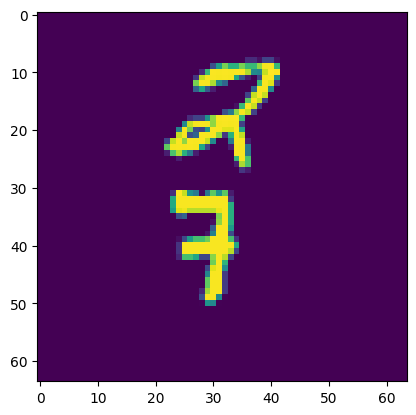

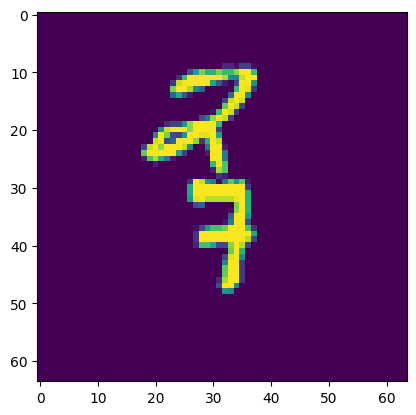

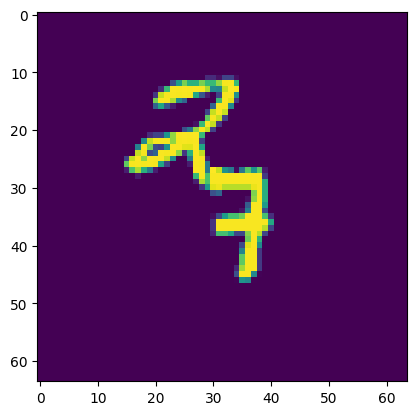

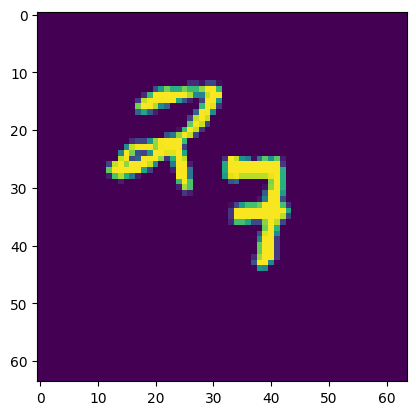

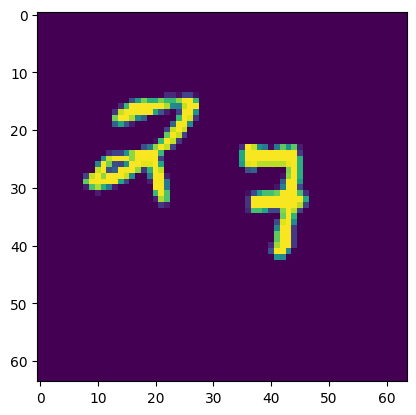

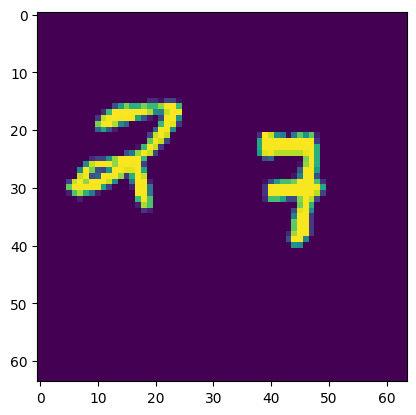

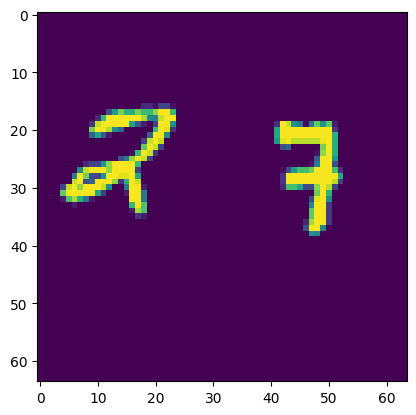

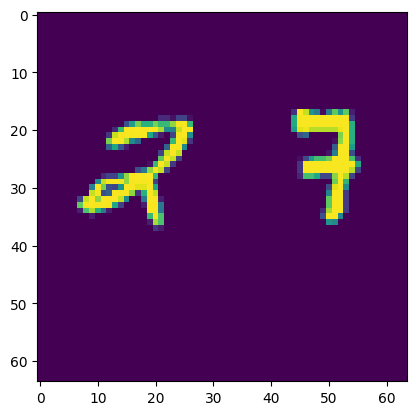

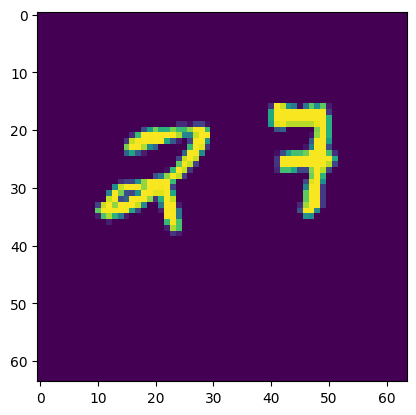

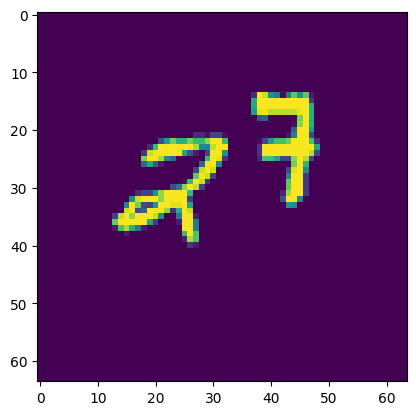

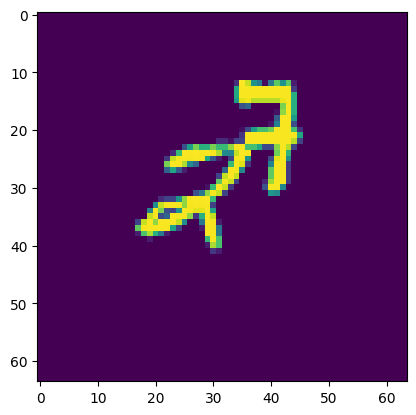

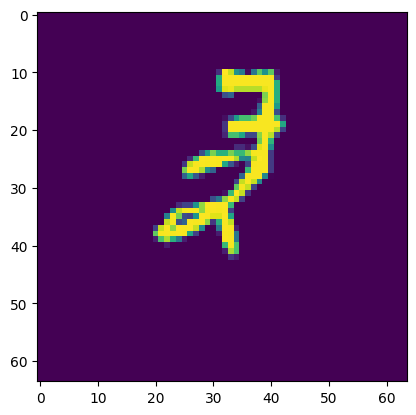

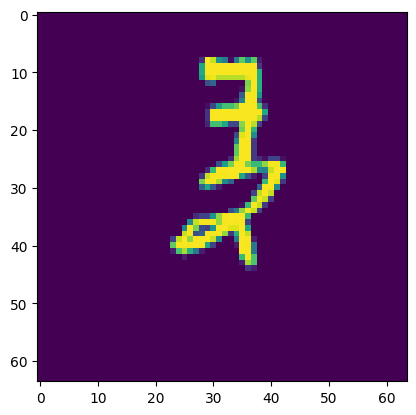

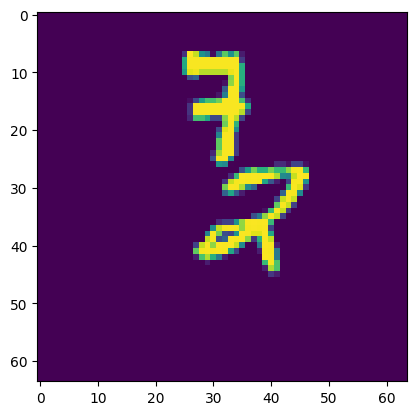

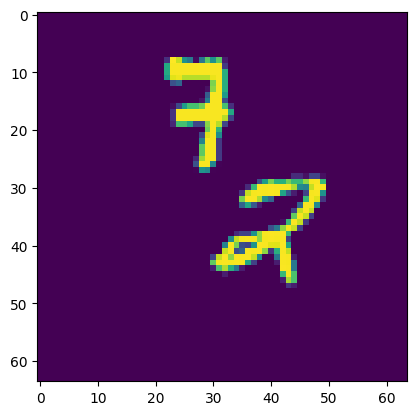

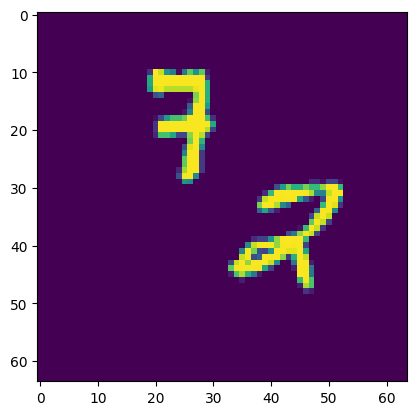

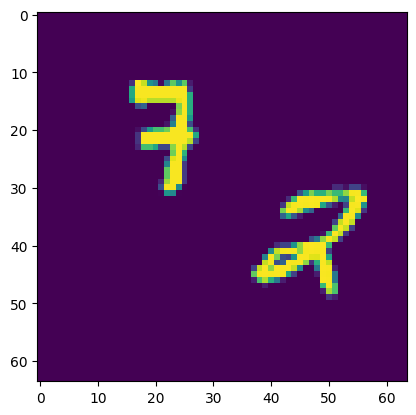

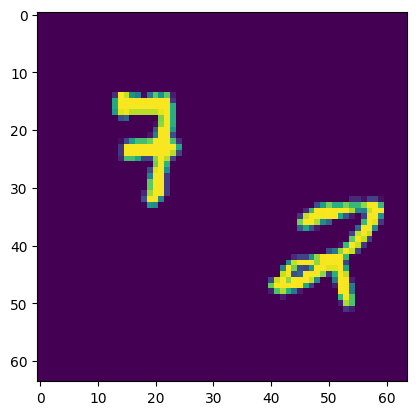

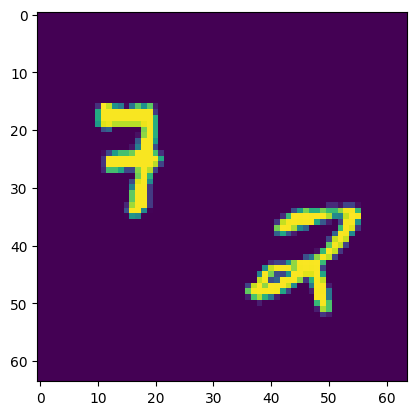

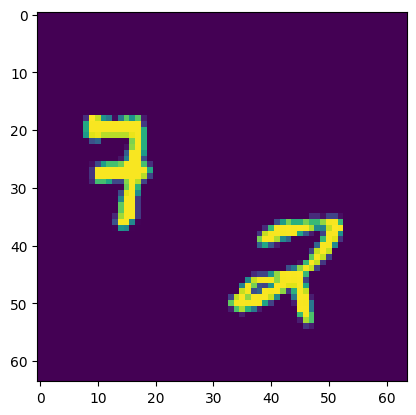

In [ ]:
i = 0
for it in dataset:
    if i > 0:
        break
    i += 1
    num = it.shape[0]
    for k in range(num):
        plt.imshow(it[k])
        plt.show()

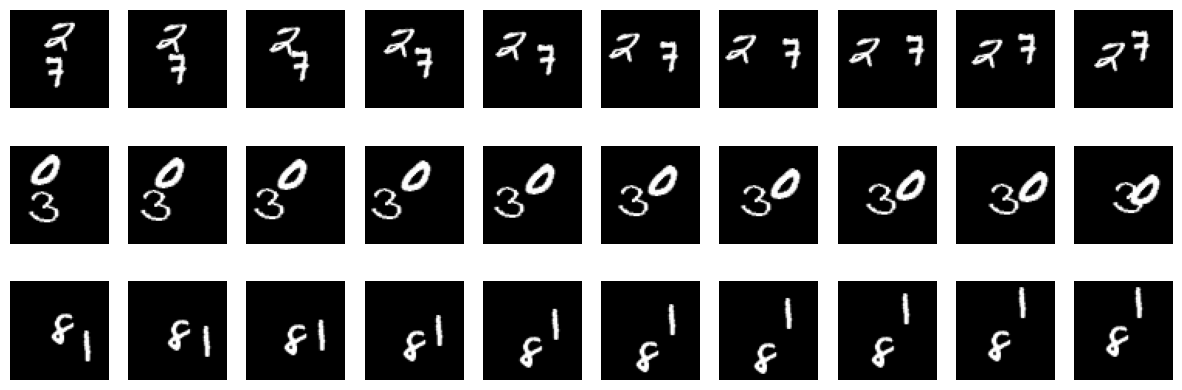

In [ ]:
# Visualize the first few sequences in the dataset
def visualize_sequences(dataset, num_sequences=3, num_frames=10):
    plt.figure(figsize=(15, 5))
    for i in range(num_sequences):
        for j in range(num_frames):
            plt.subplot(num_sequences, num_frames, i * num_frames + j + 1)
            plt.imshow(dataset[i, j], cmap='gray')
            plt.axis('off')
    plt.show()

visualize_sequences(dataset)


In [12]:
dataset = np.expand_dims(dataset, axis=-1)
indexes = np.arange(dataset.shape[0])
np.random.shuffle(indexes)
train_index = indexes[: int(0.9 * dataset.shape[0])]
val_index = indexes[int(0.9 * dataset.shape[0]) :]

In [13]:
train_dataset = dataset[train_index]
val_dataset = dataset[val_index]
train_dataset = train_dataset / 255
val_dataset = val_dataset / 255

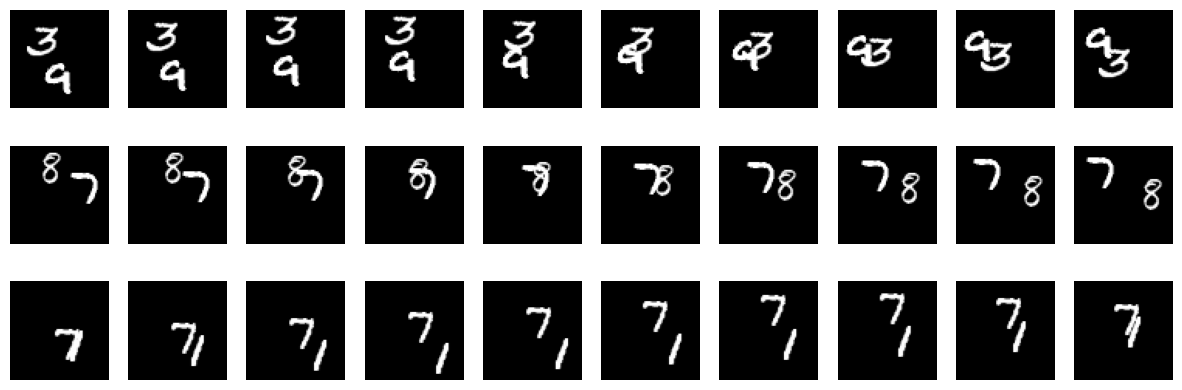

In [ ]:
# Visualize a few sequences from the training set
visualize_sequences(train_dataset)


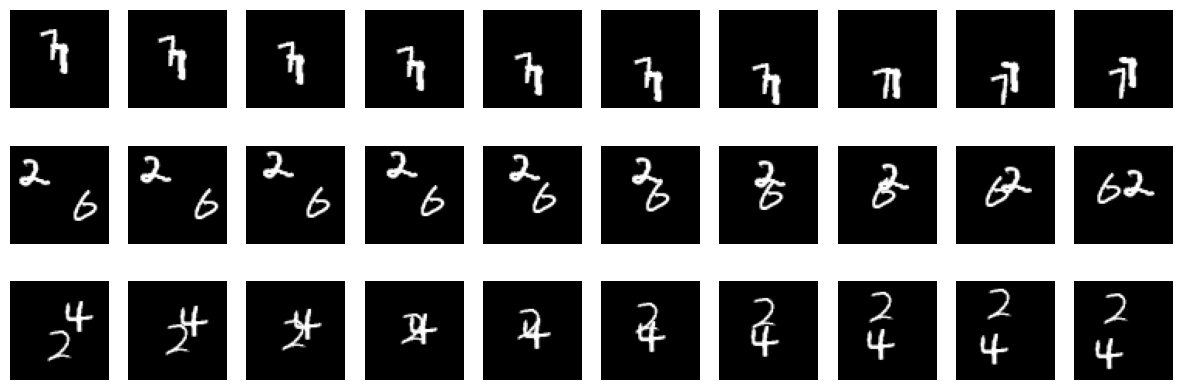

In [ ]:
# Visualize a few sequences from the validation set
visualize_sequences(val_dataset)

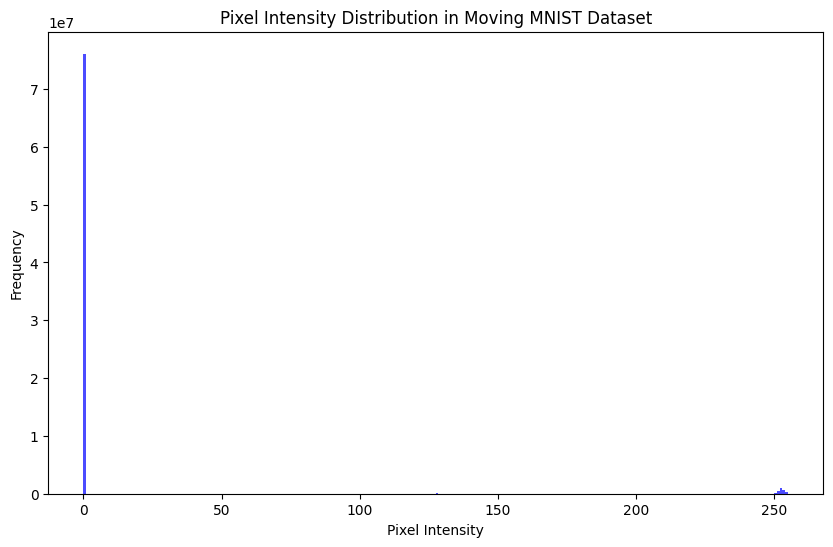

In [ ]:
def plot_intensity_histogram(dataset, title="Pixel Intensity Distribution"):
    pixel_values = dataset.flatten()
    plt.figure(figsize=(10, 6))
    plt.hist(pixel_values, bins=256, range=(0, 255), color='blue', alpha=0.7)
    plt.title(title)
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.savefig('intensity_histogram.png')
    plt.show()

plot_intensity_histogram(dataset, "Pixel Intensity Distribution in Moving MNIST Dataset")

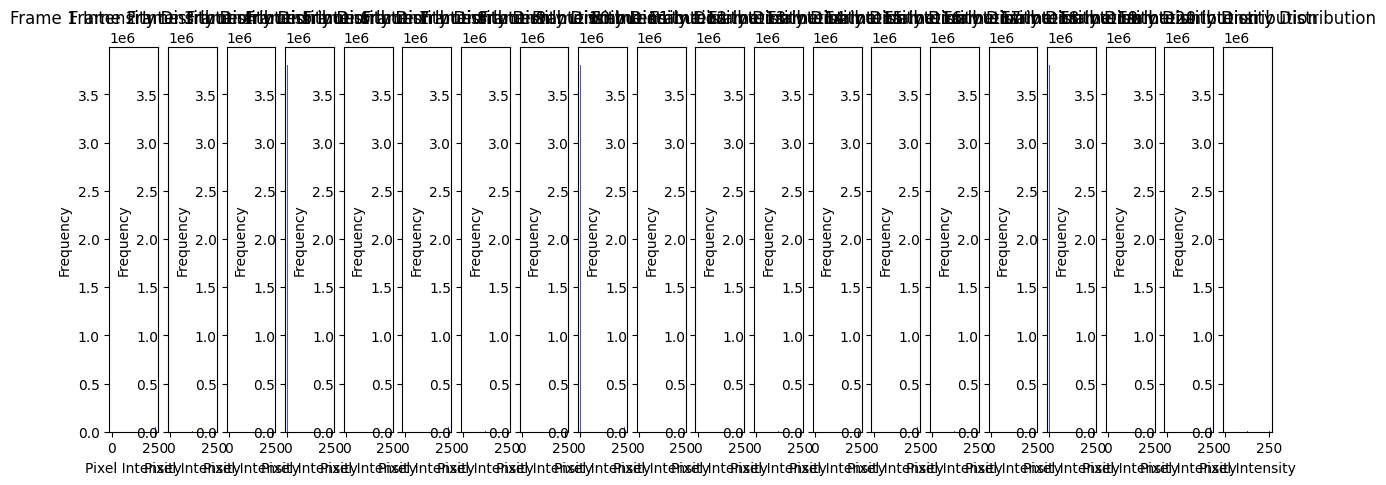

In [ ]:
# Plot frame-wise pixel intensity distributions
def plot_frame_intensity_distributions(dataset):
    num_frames = dataset.shape[1]
    plt.figure(figsize=(15, 5))
    for i in range(num_frames):
        plt.subplot(1, num_frames, i + 1)
        pixel_values = dataset[:, i].flatten()
        plt.hist(pixel_values, bins=256, range=(0, 255), color='blue', alpha=0.7)
        plt.title(f"Frame {i+1} Intensity Distribution")
        plt.xlabel("Pixel Intensity")
        plt.ylabel("Frequency")
    plt.savefig('frame_intensity_distributions.png')
    plt.show()

plot_frame_intensity_distributions(dataset)

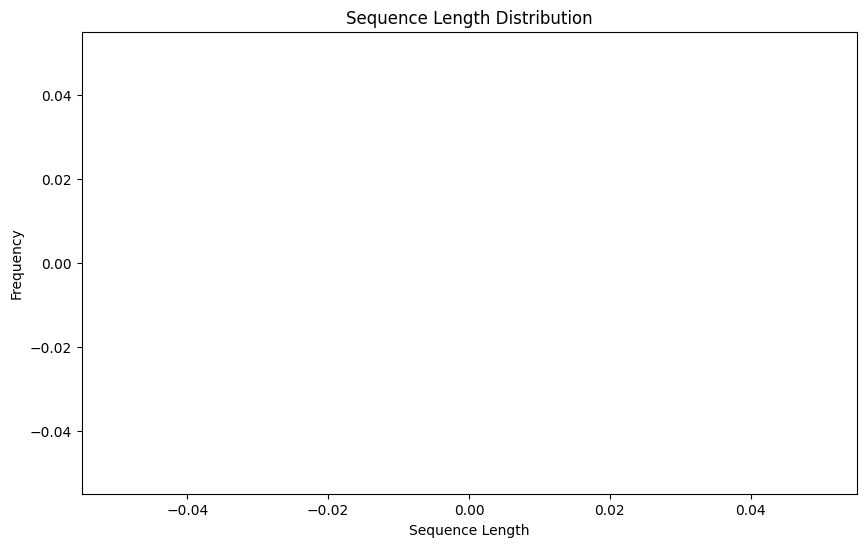

In [ ]:
# Plot sequence length distribution
def plot_sequence_length_distribution(dataset):
    sequence_lengths = [seq.shape[0] for seq in dataset]
    plt.figure(figsize=(10, 6))
    plt.hist(sequence_lengths, bins=range(min(sequence_lengths), max(sequence_lengths) + 1), color='green', alpha=0.7)
    plt.title("Sequence Length Distribution")
    plt.xlabel("Sequence Length")
    plt.ylabel("Frequency")
    plt.savefig('sequence_length_distribution.png')
    plt.show()

plot_sequence_length_distribution(dataset)

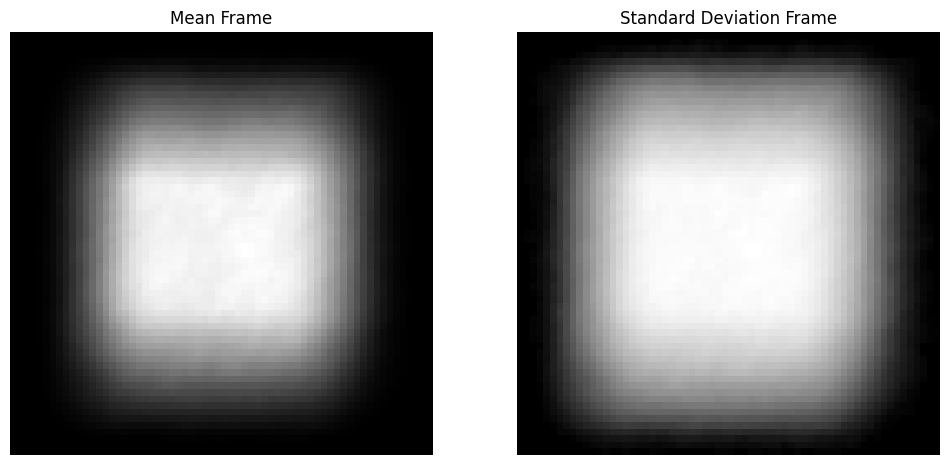

In [ ]:
# Compute and plot mean and standard deviation of frames
def plot_mean_std_frames(dataset):
    mean_frame = np.mean(dataset, axis=(0, 1))
    std_frame = np.std(dataset, axis=(0, 1))

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(mean_frame, cmap='gray')
    plt.title("Mean Frame")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(std_frame, cmap='gray')
    plt.title("Standard Deviation Frame")
    plt.axis('off')

    plt.savefig('mean_std_frames.png')
    plt.show()

plot_mean_std_frames(dataset)

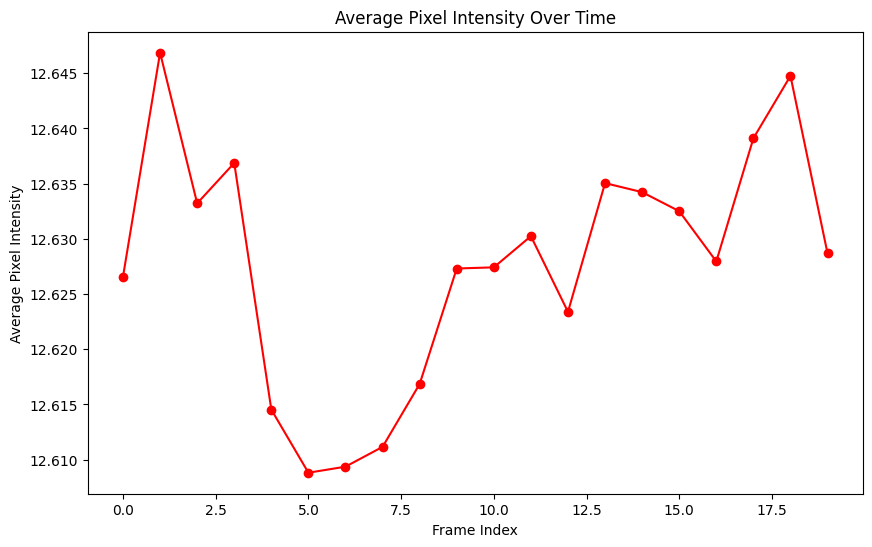

In [ ]:
# Plot average pixel intensity over time
def plot_avg_intensity_over_time(dataset):
    avg_intensity = np.mean(dataset, axis=(0, 2, 3, 4))
    plt.figure(figsize=(10, 6))
    plt.plot(avg_intensity, color='red', marker='o')
    plt.title("Average Pixel Intensity Over Time")
    plt.xlabel("Frame Index")
    plt.ylabel("Average Pixel Intensity")
    plt.savefig('avg_intensity_over_time.png')
    plt.show()

plot_avg_intensity_over_time(dataset)

## ANN Model

 **ANN (Artificial Neural Network)**:
   - The ANN model is a basic feedforward neural network.
   - It consists of multiple layers of densely connected neurons.
   - Each neuron in a layer is connected to every neuron in the subsequent layer.
   - The model is typically composed of an input layer, one or more hidden layers, and an output layer.
   - Activation functions such as ReLU (Rectified Linear Unit) or sigmoid are applied to the output of each neuron to introduce non-linearity.
   - The final layer typically uses softmax activation for multi-class classification or sigmoid activation for binary classification.
   - In the provided example, the accuracy achieved by the ANN model is 0.0%.





In [10]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers, Sequential



In [23]:
# Create shifted frames for training and validation datasets
def create_shifted_frames(data):
    x = data[:, 0 : data.shape[1] - 1, :, :]
    y = data[:, 1 : data.shape[1], :, :]
    return x, y

x_train, y_train = create_shifted_frames(train_dataset[:100])
x_val, y_val = create_shifted_frames(val_dataset[:20])

# Normalize the data
x_train = x_train / 255.0
y_train = y_train / 255.0
x_val = x_val / 255.0
y_val = x_val / 255.0

x_train_flat = x_train.reshape((x_train.shape[0], -1))
y_train_flat = y_train.reshape((y_train.shape[0], -1))
x_val_flat = x_val.reshape((x_val.shape[0], -1))
y_val_flat = y_val.reshape((y_val.shape[0], -1))

In [24]:
# Define the ANN model with increased capacity
def create_ann_model(input_shape, output_shape):
    model = Sequential([
        layers.Dense(1024, activation='relu', input_shape=(input_shape,)),
        layers.Dense(512, activation='relu'),
        layers.Dense(256, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(output_shape, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model



In [25]:
ann_model = create_ann_model(x_train_flat.shape[1], y_train_flat.shape[1])

# Train the model without early stopping or learning rate reduction
ann_history = ann_model.fit(x_train_flat, y_train_flat, epochs=50, batch_size=5, validation_data=(x_val_flat, y_val_flat))

Epoch 1/50
20/20 [==============================] - 3s 54ms/step - loss: 0.6868 - accuracy: 0.0000e+00 - val_loss: 0.6516 - val_accuracy: 0.0000e+00
Epoch 2/50
20/20 [==============================] - 1s 42ms/step - loss: 0.1762 - accuracy: 0.0000e+00 - val_loss: 3.5807e-05 - val_accuracy: 0.0000e+00
Epoch 3/50
20/20 [==============================] - 1s 42ms/step - loss: 0.0126 - accuracy: 0.0000e+00 - val_loss: 5.3674e-05 - val_accuracy: 0.0000e+00
Epoch 4/50
20/20 [==============================] - 1s 42ms/step - loss: 0.0108 - accuracy: 0.0000e+00 - val_loss: 3.2089e-05 - val_accuracy: 0.0000e+00
Epoch 5/50
20/20 [==============================] - 1s 45ms/step - loss: 0.0052 - accuracy: 0.0000e+00 - val_loss: 4.2440e-04 - val_accuracy: 0.0000e+00
Epoch 6/50
20/20 [==============================] - 1s 45ms/step - loss: 0.0025 - accuracy: 0.0000e+00 - val_loss: 1.6095e-04 - val_accuracy: 0.0000e+00
Epoch 7/50
20/20 [==============================] - 1s 45ms/step - loss: 0.0022 - accu

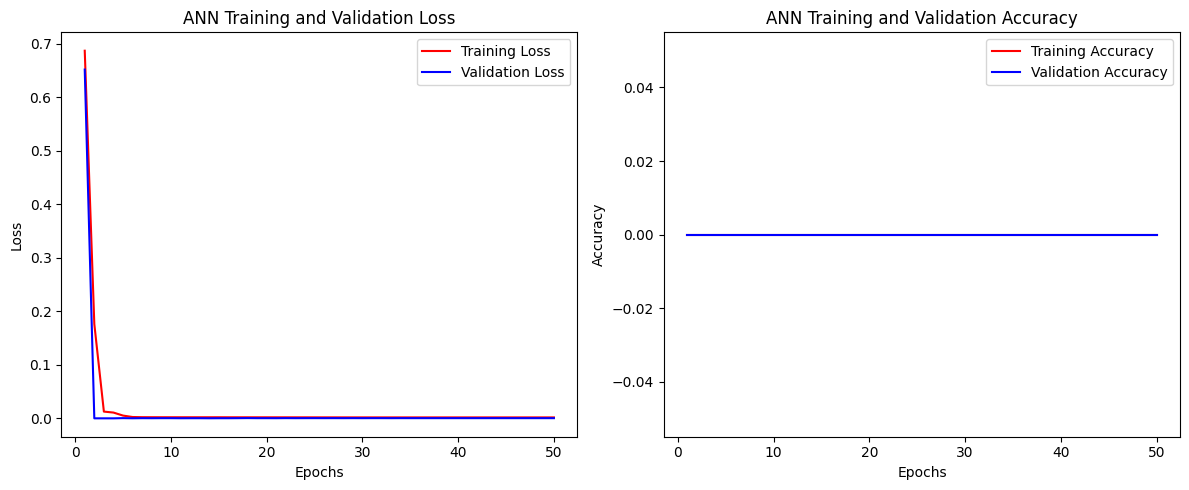

In [26]:
# Plotting Loss and Accuracy for ANN
def plot_history(history, model_name):
    epochs = range(1, len(history.history['loss']) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['loss'], 'r', label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], 'b', label='Validation Loss')
    plt.title(f'{model_name} Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['accuracy'], 'r', label='Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], 'b', label='Validation Accuracy')
    plt.title(f'{model_name} Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.savefig(f'{model_name}_training_validation.png')
    plt.show()

plot_history(ann_history, 'ANN')

##CNN Model

 **CNN (Convolutional Neural Network)**:
   - The CNN model is specialized for processing grid-like data, such as images.
   - It consists of convolutional layers followed by pooling layers.
   - Convolutional layers apply filters to input images to detect spatial patterns.
   - Pooling layers reduce the dimensionality of the feature maps generated by convolutional layers.
   - CNNs use operations like convolution and pooling to learn spatial hierarchies of features.
   - The final layers are typically fully connected layers followed by softmax or sigmoid activation for classification.
   - In the provided example, the CNN model achieved an accuracy of 92.60%.

In [31]:
# Create shifted frames for training and validation datasets
def create_shifted_frames(data):
    x = data[:, 0 : data.shape[1] - 1, :, :]
    y = data[:, 1 : data.shape[1], :, :]
    return x, y

# Using only a small portion of the dataset to intentionally overfit
x_train, y_train = create_shifted_frames(train_dataset[:100])  # Use only 100 samples
x_val, y_val = create_shifted_frames(val_dataset[:20])  # Use only 20 samples

# Normalize the data
x_train = x_train / 255.0
y_train = y_train / 255.0
x_val = x_val / 255.0
y_val = x_val / 255.0

In [41]:
# Define the CNN model with increased capacity
def create_cnn_model(input_shape):
    model = Sequential([
        layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape, padding='same'),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [42]:
cnn_model = create_cnn_model(x_train.shape[1:])

# Train the model without early stopping or learning rate reduction
cnn_history = cnn_model.fit(x_train, y_train, epochs=50, batch_size=5, validation_data=(x_val, y_val))

Epoch 1/50
20/20 [==============================] - 6s 81ms/step - loss: 0.5675 - accuracy: 0.9227 - val_loss: 0.2845 - val_accuracy: 0.9248
Epoch 2/50
20/20 [==============================] - 1s 42ms/step - loss: 0.0827 - accuracy: 0.9260 - val_loss: 0.0043 - val_accuracy: 0.9248
Epoch 3/50
20/20 [==============================] - 1s 41ms/step - loss: 0.0033 - accuracy: 0.9260 - val_loss: 8.2067e-04 - val_accuracy: 0.9248
Epoch 4/50
20/20 [==============================] - 1s 41ms/step - loss: 0.0024 - accuracy: 0.9260 - val_loss: 5.9105e-04 - val_accuracy: 0.9248
Epoch 5/50
20/20 [==============================] - 1s 42ms/step - loss: 0.0024 - accuracy: 0.9260 - val_loss: 5.3389e-04 - val_accuracy: 0.9248
Epoch 6/50
20/20 [==============================] - 1s 42ms/step - loss: 0.0024 - accuracy: 0.9260 - val_loss: 4.5463e-04 - val_accuracy: 0.9248
Epoch 7/50
20/20 [==============================] - 1s 43ms/step - loss: 0.0023 - accuracy: 0.9260 - val_loss: 3.6268e-04 - val_accuracy: 

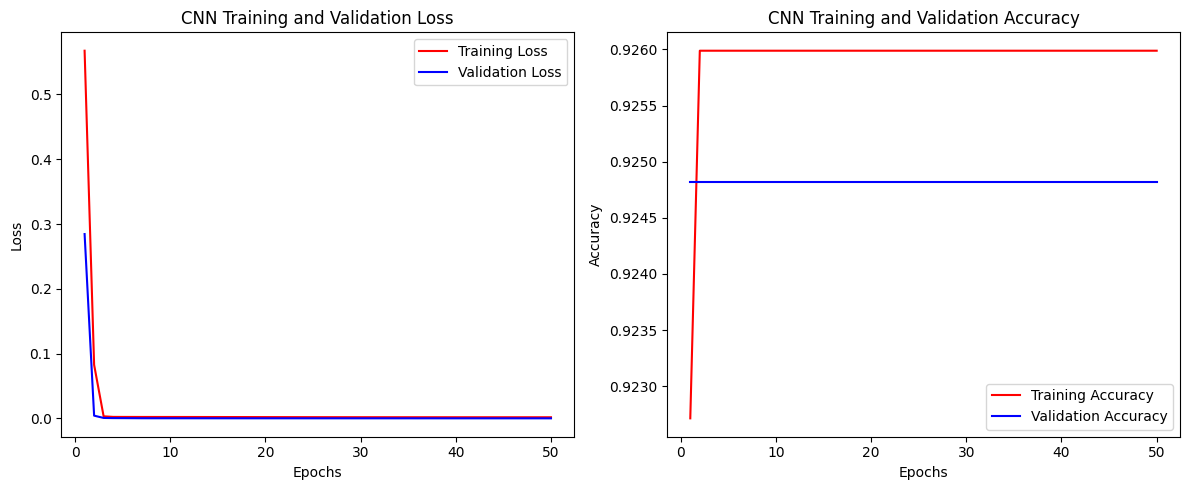

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 19, 64, 64, 64)    640       
                                                                 
 conv2d_21 (Conv2D)          (None, 19, 64, 64, 64)    36928     
                                                                 
 conv2d_22 (Conv2D)          (None, 19, 64, 64, 1)     577       
                                                                 
Total params: 38145 (149.00 KB)
Trainable params: 38145 (149.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [43]:
# Plotting Loss and Accuracy for CNN
def plot_history(history, model_name):
    epochs = range(1, len(history.history['loss']) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['loss'], 'r', label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], 'b', label='Validation Loss')
    plt.title(f'{model_name} Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['accuracy'], 'r', label='Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], 'b', label='Validation Accuracy')
    plt.title(f'{model_name} Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.savefig(f'{model_name}_training_validation.png')
    plt.show()

plot_history(cnn_history, 'CNN')

# Check the model summary
cnn_model.summary()

## CONVLSTM Model

In [ ]:
def create_shifted_frames(data):
    x = data[:, 0 : data.shape[1] - 1, :, :]
    y = data[:, 1 : data.shape[1], :, :]
    return x, y

In [ ]:
x_train, y_train = create_shifted_frames(train_dataset)
x_val, y_val = create_shifted_frames(val_dataset)
print(f"Training Dataset Shapes: {str(x_train.shape)}, {str(y_train.shape)}")

Training Dataset Shapes: (900, 19, 64, 64, 1), (900, 19, 64, 64, 1)


In [ ]:
from tensorflow.keras.layers import ConvLSTM2D, BatchNormalization, Conv3D
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential

This code defines a Convolutional LSTM (Long Short-Term Memory) model architecture for a sequential data task.The architecture step by step:

1. **Sequential Model Initialization**:
    - The model is initialized using `Sequential` from Keras, and it's named "Conv_LSTM".

2. **ConvLSTM Layers**:
    - Three `ConvLSTM2D` layers are stacked one after another. These layers are capable of processing spatiotemporal data efficiently.
    - `ConvLSTM2D` layers perform convolutional operations within the LSTM framework, enabling them to learn spatial and temporal patterns simultaneously.
    - Each `ConvLSTM2D` layer has 64 filters.
    - The first layer (`convlstm1`) has a larger kernel size of (5, 5), capturing larger spatial contexts initially.
    - The subsequent layers (`convlstm2` and `convlstm3`) have smaller kernel sizes of (3, 3) and (1, 1) respectively, allowing them to capture more detailed spatial features and temporal dynamics.

3. **Batch Normalization**:
    - `BatchNormalization` layers are added after each `ConvLSTM2D` layer.
    - Batch normalization helps stabilize and accelerate the training process by normalizing the input to each layer.

4. **3D Convolution Layer**:
    - After the stack of `ConvLSTM2D` layers, a `Conv3D` layer is added.
    - This layer aggregates the spatiotemporal information learned by the previous layers and produces the final output.
    - It has a single filter with a kernel size of (3, 3, 3) and uses the sigmoid activation function to produce binary classification outputs.

5. **Compilation**:
    - The model is compiled using binary cross-entropy loss (`binary_crossentropy`) since it's a binary classification task.
    - Adam optimizer is used for optimization, and accuracy is chosen as the evaluation metric.

6. **Return**:
    - The model is returned for training and evaluation.

Overall, this architecture is designed to capture both spatial and temporal dependencies in sequential data.

In [ ]:
def create_model():
    model = Sequential(name="Conv_LSTM")
    convlstm1 = ConvLSTM2D(filters=64,kernel_size=(5, 5),padding="same",activation="relu",return_sequences=True,input_shape=(None, *x_train.shape[2:]))
    convlstm2 = ConvLSTM2D(filters=64,kernel_size=(3, 3),padding="same",activation="relu",return_sequences=True)
    convlstm3 = ConvLSTM2D(filters=64,kernel_size=(1, 1),padding="same",activation="relu",return_sequences=True)
    conv = Conv3D(filters=1,kernel_size=(3, 3, 3),padding="same",activation="sigmoid")

    model.add(convlstm1)
    model.add(BatchNormalization())
    model.add(convlstm2)
    model.add(BatchNormalization())
    model.add(convlstm3)
    model.add(conv)

    model.compile(loss = binary_crossentropy,optimizer=Adam(),metrics=['accuracy'])

    return model

In [ ]:
EPOCHS = 50
BATCH_SIZE = 5
MODEL_PATH = f"/content/trained/conv_lstm.h5"

In [ ]:
model = create_model()
model.summary()

Model: "Conv_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, None, 64, 64, 64   416256    
                             )                                   
                                                                 
 batch_normalization (Batch  (None, None, 64, 64, 64   256       
 Normalization)              )                                   
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, None, 64, 64, 64   295168    
                             )                                   
                                                                 
 batch_normalization_1 (Bat  (None, None, 64, 64, 64   256       
 chNormalization)            )                                   
                                                                 
 conv_lstm2d_2 (ConvLSTM2D)  (None, None, 64, 64, 64   33

## Training and testing of model

In [ ]:
history = model.fit(
    x_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(x_val, y_val),
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=10),
        keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)
    ],
)
model.save(MODEL_PATH)

Epoch 1/50


2023-11-08 13:20:37.934934: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: MutableGraphView::SortTopologically error: detected edge(s) creating cycle(s) {'Func/gradient_tape/Conv_LSTM/conv_lstm2d_8/while/Conv_LSTM/conv_lstm2d_8/while_grad/body/_555/input/_1530' -> 'gradient_tape/Conv_LSTM/conv_lstm2d_8/while/Conv_LSTM/conv_lstm2d_8/while_grad/body/_555/gradient_tape/Conv_LSTM/conv_lstm2d_8/while/gradients/AddN', 'Func/gradient_tape/Conv_LSTM/conv_lstm2d_7/while/Conv_LSTM/conv_lstm2d_7/while_grad/body/_750/input/_1649' -> 'gradient_tape/Conv_LSTM/conv_lstm2d_7/while/Conv_LSTM/conv_lstm2d_7/while_grad/body/_750/gradient_tape/Conv_LSTM/conv_lstm2d_7/while/gradients/AddN', 'Func/gradient_tape/Conv_LSTM/conv_lstm2d_6/while/Conv_LSTM/conv_lstm2d_6/while_grad/body/_945/input/_1765' -> 'gradient_tape/Conv_LSTM/conv_lstm2d_6/while/Conv_LSTM/conv_lstm2d_6/while_grad/body/_945/gradient_tape/Conv_LSTM/conv_lstm2d_6/while/gradients/AddN', 'Conv_LSTM/co

180/180 [==============================] - ETA: 0s - loss: 0.0694 - accuracy: 0.9264

2023-11-08 13:22:09.677220: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: MutableGraphView::SortTopologically error: detected edge(s) creating cycle(s) {'Conv_LSTM/conv_lstm2d_8/while/body/_97/Conv_LSTM/conv_lstm2d_8/while/convolution_6' -> 'Conv_LSTM/conv_lstm2d_8/while/body/_97/Conv_LSTM/conv_lstm2d_8/while/add_4', 'Conv_LSTM/conv_lstm2d_8/while/body/_97/Conv_LSTM/conv_lstm2d_8/while/clip_by_value' -> 'Conv_LSTM/conv_lstm2d_8/while/body/_97/Conv_LSTM/conv_lstm2d_8/while/mul_3', 'Conv_LSTM/conv_lstm2d_8/while/body/_97/Conv_LSTM/conv_lstm2d_8/while/mul_2' -> 'Conv_LSTM/conv_lstm2d_8/while/body/_97/Conv_LSTM/conv_lstm2d_8/while/add_5', 'Conv_LSTM/conv_lstm2d_8/while/body/_97/Conv_LSTM/conv_lstm2d_8/while/clip_by_value_2' -> 'Conv_LSTM/conv_lstm2d_8/while/body/_97/Conv_LSTM/conv_lstm2d_8/while/mul_5', 'Conv_LSTM/conv_lstm2d_7/while/body/_49/Conv_LSTM/conv_lstm2d_7/while/convolution_6' -> 'Conv_LSTM/conv_lstm2d_7/while/body/_49/Conv_LSTM/con

180/180 [==============================] - 99s 474ms/step - loss: 0.0694 - accuracy: 0.9264 - val_loss: 0.2211 - val_accuracy: 0.9288 - lr: 0.0010
Epoch 2/50
180/180 [==============================] - 84s 469ms/step - loss: 0.0282 - accuracy: 0.9311 - val_loss: 0.2602 - val_accuracy: 0.9288 - lr: 0.0010
Epoch 3/50
180/180 [==============================] - 84s 469ms/step - loss: 0.0265 - accuracy: 0.9311 - val_loss: 0.0791 - val_accuracy: 0.9297 - lr: 0.0010
Epoch 4/50
180/180 [==============================] - 84s 469ms/step - loss: 0.0261 - accuracy: 0.9310 - val_loss: 0.0297 - val_accuracy: 0.9322 - lr: 0.0010
Epoch 5/50
180/180 [==============================] - 84s 469ms/step - loss: 0.0257 - accuracy: 0.9310 - val_loss: 0.0252 - val_accuracy: 0.9320 - lr: 0.0010
Epoch 6/50
180/180 [==============================] - 84s 469ms/step - loss: 0.0254 - accuracy: 0.9310 - val_loss: 0.0245 - val_accuracy: 0.9321 - lr: 0.0010
Epoch 7/50
180/180 [==============================] - 84s 469ms

**Due to multiple runtime disconnect the model history  cannote be saved so i have to plot the graph like below**

In [ ]:
import matplotlib.pyplot as plt

epochs = list(range(1, 42))  # Now, we have 41 epochs

loss = [0.0694, 0.0282, 0.0265, 0.0261, 0.0257, 0.0254, 0.0250, 0.0248, 0.0247, 0.0246, 0.0244, 0.0244, 0.0243, 0.0243, 0.0242, 0.0242, 0.0242, 0.0241, 0.0241, 0.0241, 0.0240, 0.0240, 0.0238, 0.0238, 0.0238, 0.0237, 0.0237, 0.0237, 0.0237, 0.0237, 0.0237, 0.0237, 0.0237, 0.0237, 0.0237, 0.0237, 0.0237, 0.0237, 0.0237, 0.0237, 0.0237]
accuracy = [0.9264, 0.9311, 0.9311, 0.9310, 0.9310, 0.9310, 0.9310, 0.9311, 0.9311, 0.9310, 0.9311, 0.9311, 0.9311, 0.9311, 0.9311, 0.9311, 0.9311, 0.9311, 0.9311, 0.9311, 0.9311, 0.9311, 0.9311, 0.9311, 0.9311, 0.9311, 0.9311, 0.9311, 0.9311, 0.9311, 0.9311, 0.9311, 0.9311, 0.9311, 0.9311, 0.9311, 0.9311, 0.9311, 0.9311, 0.9311, 0.9311]
val_loss = [0.2211, 0.2602, 0.0791, 0.0297, 0.0252, 0.0245, 0.0247, 0.0244, 0.0241, 0.0244, 0.0241, 0.0238, 0.0242, 0.0239, 0.0239, 0.0238, 0.0237, 0.0241, 0.0238, 0.0237, 0.0238, 0.0237, 0.0234, 0.0234, 0.0234, 0.0234, 0.0234, 0.0235, 0.0234, 0.0234, 0.0234, 0.0233, 0.0233, 0.0233, 0.0233, 0.0233, 0.0233, 0.0233, 0.0233, 0.0233, 0.0233, 0.0233]
val_accuracy = [0.9288, 0.9288, 0.9297, 0.9322, 0.932, 0.9321, 0.9321, 0.9319, 0.9319, 0.9321, 0.932, 0.932, 0.9321, 0.9318, 0.9321, 0.9321, 0.932, 0.9321, 0.9319, 0.932, 0.9321, 0.9319, 0.932, 0.932, 0.932, 0.932, 0.9319, 0.932, 0.932, 0.932, 0.932, 0.932, 0.932, 0.932, 0.932, 0.932, 0.932, 0.932, 0.932, 0.932, 0.932, 0.932, 0.932, 0.932, 0.932]



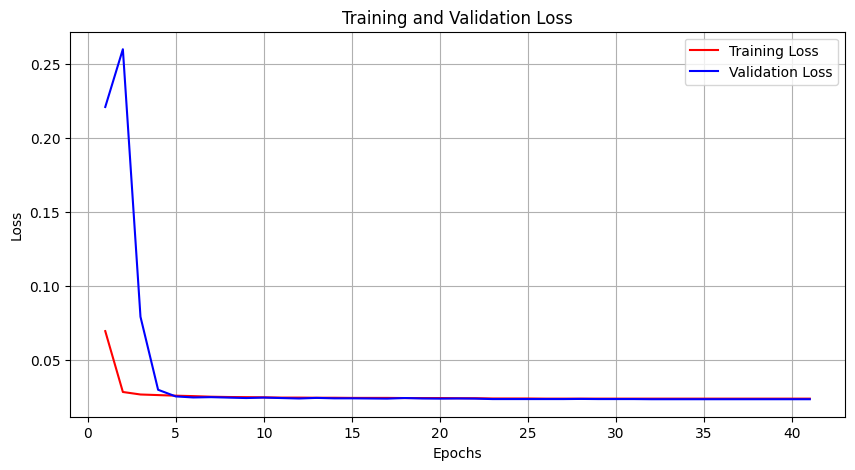

In [ ]:

# Plotting Loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, loss[:len(epochs)], 'r', label='Training Loss')
plt.plot(epochs, val_loss[:len(epochs)], 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('loss_plot.png')
plt.grid(True)
plt.show()



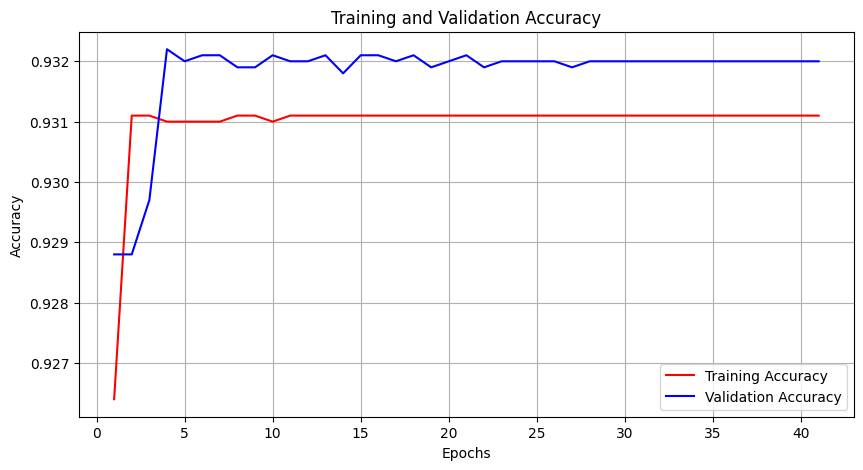

In [ ]:
# Plotting Accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, accuracy[:len(epochs)], 'r', label='Training Accuracy')
plt.plot(epochs, val_accuracy[:len(epochs)], 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('accuracy_plot.png')
plt.grid(True)
plt.show()

## prediction

1/1 [==============================] - 0s 61ms/step


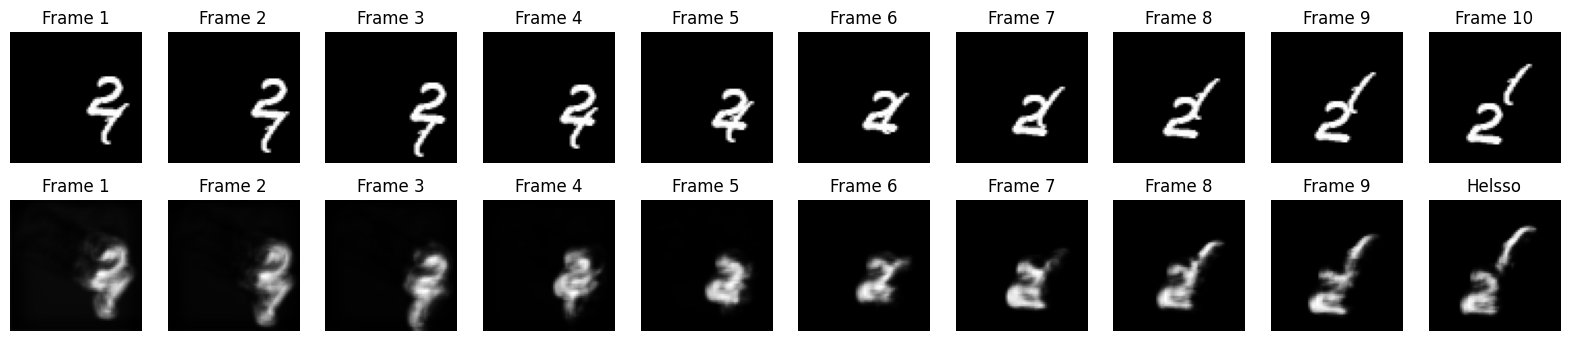

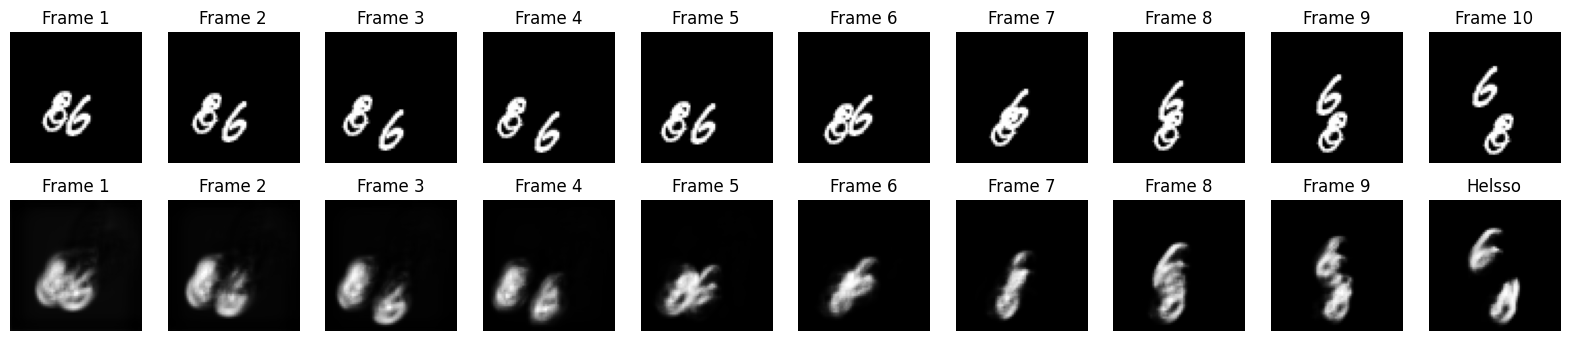

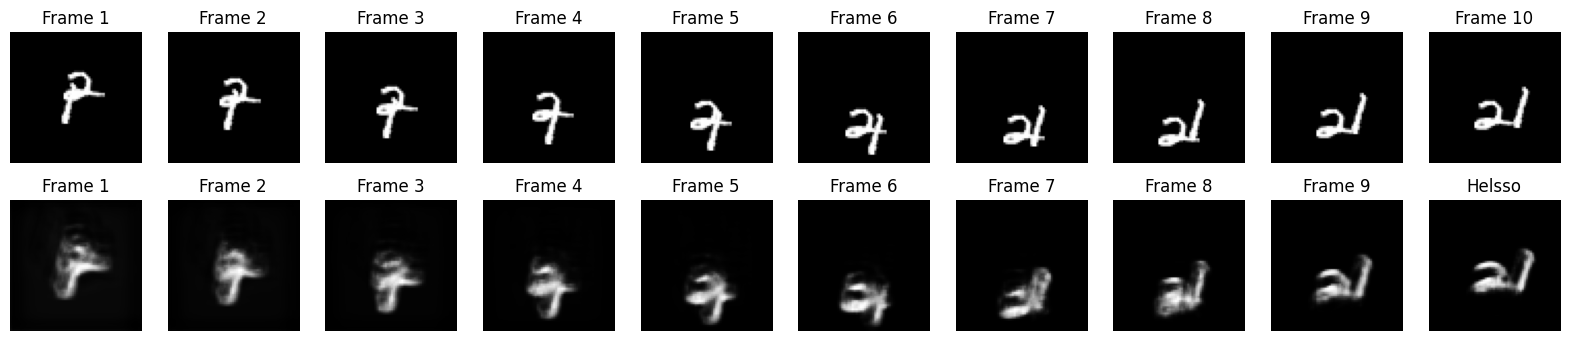

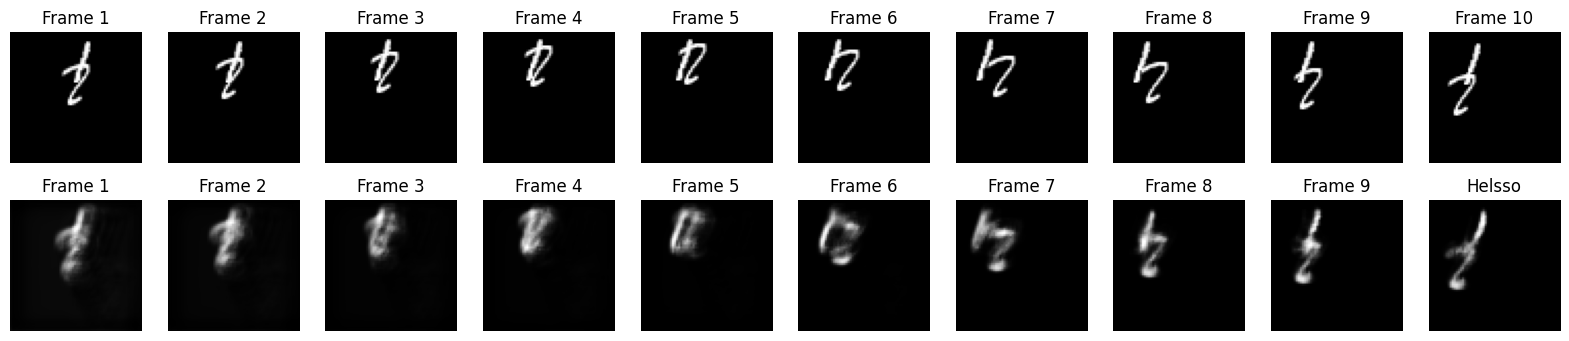

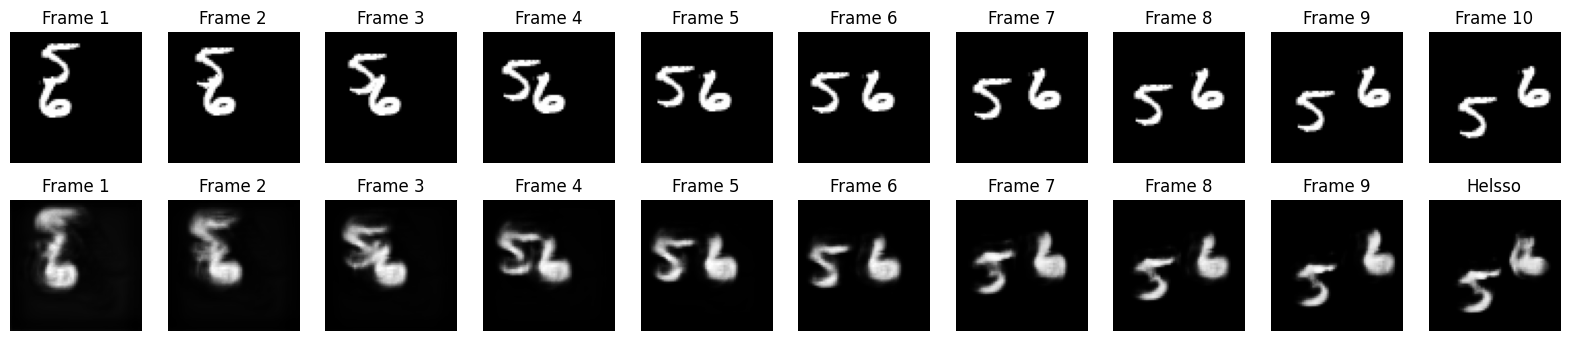

In [ ]:
examples = val_dataset[np.random.choice(range(len(val_dataset)), size=5)]
predicted_videos = []

for example in examples:

    frames = example[:10, ...]
    original_frames = example[10:, ...]
    new_predictions = np.zeros(shape=(10, *frames[0].shape))

    for i in range(10):

        frames = example[: 10 + i + 1, ...]
        new_prediction = model.predict(np.expand_dims(frames, axis=0))
        new_prediction = np.squeeze(new_prediction, axis=0)
        predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

        new_predictions[i] = predicted_frame

    fig, axes = plt.subplots(2, 10, figsize=(20, 4))

    for idx, ax in enumerate(axes[0]):
        ax.imshow(np.squeeze(original_frames[idx]), cmap="gray")
        ax.set_title(f"Frame {idx + 1}")
        ax.axis("off")
    for idx, ax in enumerate(axes[1]):
        ax.imshow(np.squeeze(new_predictions[idx]), cmap="gray")
        ax.set_title(f"Frame {idx+1}")
        ax.axis("off")

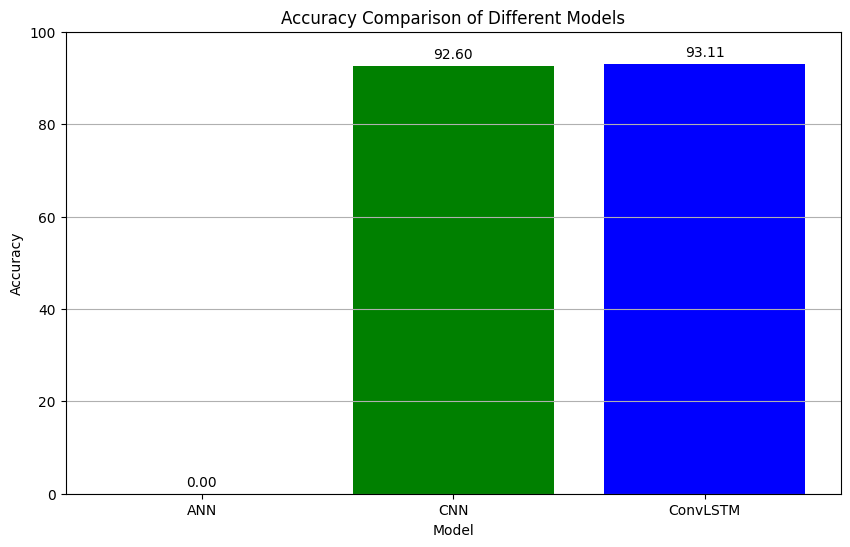

In [45]:
import matplotlib.pyplot as plt

# Accuracy values
ann_accuracy = 0.0  # Replace with actual value
cnn_accuracy = 92.60  # Replace with actual value
convlstm_accuracy = 93.11  # Replace with actual value

# Model names
models = ['ANN', 'CNN', 'ConvLSTM']

# Accuracy values
accuracies = [ann_accuracy, cnn_accuracy, convlstm_accuracy]

# Plotting bar graph for accuracy comparison
plt.figure(figsize=(10, 6))
bars = plt.bar(models, accuracies, color=['red', 'green', 'blue'])
plt.title('Accuracy Comparison of Different Models')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0, 100)  # Set the y-axis limit to 0-100 for percentage
plt.grid(axis='y')

# Adding text labels on top of each bar
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1, f'{acc:.2f}', ha='center', va='bottom')

plt.savefig('accuracy_comparison_bar_with_values.png')
plt.show()
